In [35]:
# Import libraries required to do operations like convolution, gaussian blur, sobel operator, pixel manipulation, etc.

import imageio
from skimage import morphology
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt

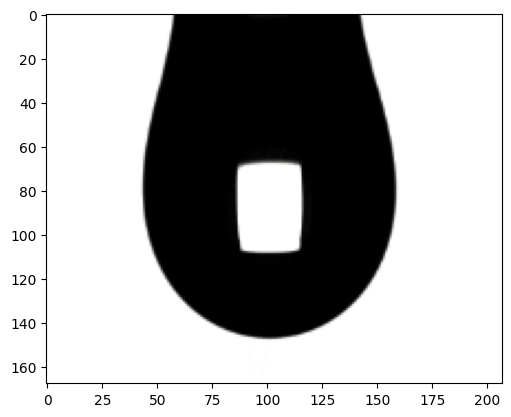

In [36]:
# Load image into variable and display it
lion = imageio.v2.imread("example_images/cropped/cropped SLES 70 8% w-w in DI Water.png", None) # Paste address of image
plt.imshow(lion, cmap = plt.get_cmap('gray'))
plt.show()

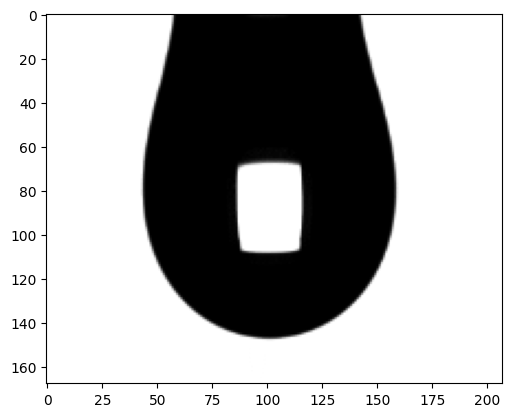

In [37]:
# Convert color image to grayscale to help extraction of edges and plot it
lion_gray = np.dot(lion[...,:3], [0.299, 0.587, 0.114])
#lion_gray = lion_gray.astype('int32')
plt.imshow(lion_gray, cmap = plt.get_cmap('gray'))
plt.show()

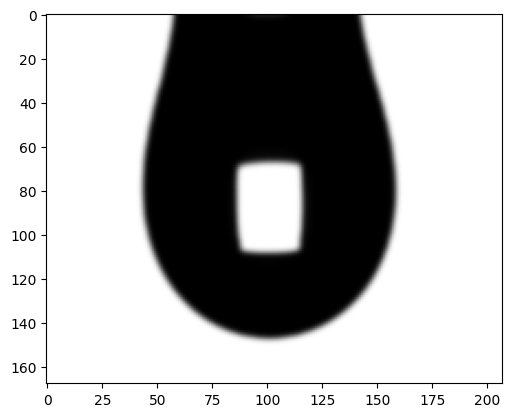

In [38]:
# Blur the grayscale image so that only important edges are extracted and the noisy ones ignored
lion_gray_blurred = ndimage.gaussian_filter(lion_gray, sigma=1.2) # Note that the value of sigma is image specific so please tune it
plt.imshow(lion_gray_blurred, cmap = plt.get_cmap('gray'))
plt.show()

In [39]:
# Apply Sobel Filter using the convolution operation
# Note that in this case I have used the filter to have a maximum magnitude of 2, but it can also be changed to other numbers for aggressive edge extraction
# For eg [-1,0,1], [-5,0,5], [-1,0,1]
def SobelFilter(img, direction):
    if(direction == 'x'):
        Gx = np.array([[-1,0,+1], [-2,0,+2],  [-1,0,+1]])
        Res = ndimage.convolve(img, Gx)
        #Res = ndimage.convolve(img, Gx, mode='constant', cval=0.0)
    if(direction == 'y'):
        Gy = np.array([[-1,-2,-1], [0,0,0], [+1,+2,+1]])
        Res = ndimage.convolve(img, Gy)
        #Res = ndimage.convolve(img, Gy, mode='constant', cval=0.0)
    
    return Res

In [40]:
# Normalize the pixel array, so that values are <= 1
def Normalize(img):
    #img = np.multiply(img, 255 / np.max(img))
    img = img/np.max(img)
    return img

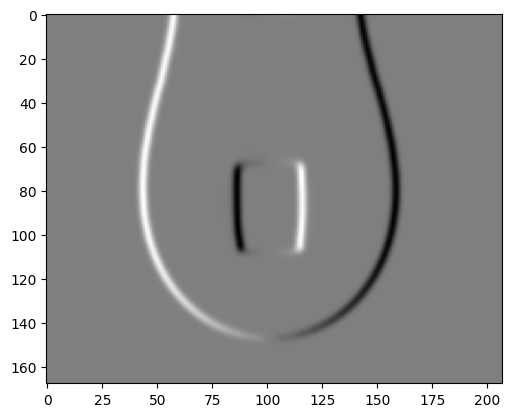

In [41]:
# Apply Sobel Filter in X direction
gx = SobelFilter(lion_gray_blurred, 'x')
gx = Normalize(gx)
plt.imshow(gx, cmap = plt.get_cmap('gray'))
plt.show()

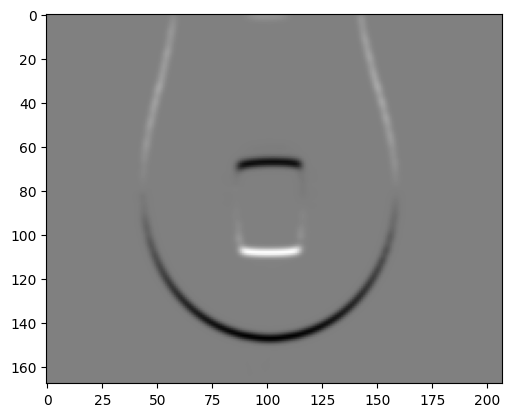

In [42]:
# Apply Sobel Filter in Y direction
gy = SobelFilter(lion_gray_blurred, 'y')
gy = Normalize(gy)
plt.imshow(gy, cmap = plt.get_cmap('gray'))
plt.show()

In [43]:
# Apply the Sobel Filter using the inbuilt function of scipy, this was done to verify the values obtained from above
# Also differnet modes can be tried out for example as given below:
#dx = ndimage.sobel(lion_gray_blurred, axis=1, mode='constant', cval=0.0)  # horizontal derivative
#dy = ndimage.sobel(lion_gray_blurred, axis=0, mode='constant', cval=0.0)  # vertical derivative

dx = ndimage.sobel(lion_gray_blurred, axis=1) # horizontal derivative
dy = ndimage.sobel(lion_gray_blurred, axis=0) # vertical derivative

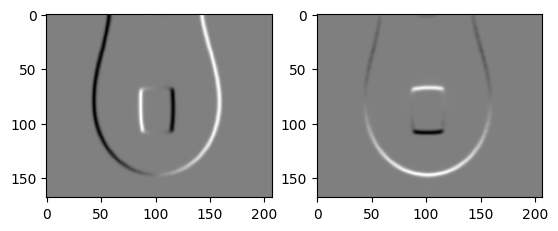

In [44]:
# Plot the derivative filter values obtained using the inbuilt function
plt.subplot(121)
plt.imshow(dx, cmap = plt.get_cmap('gray'))
plt.subplot(122)
plt.imshow(dy, cmap = plt.get_cmap('gray'))
plt.show()

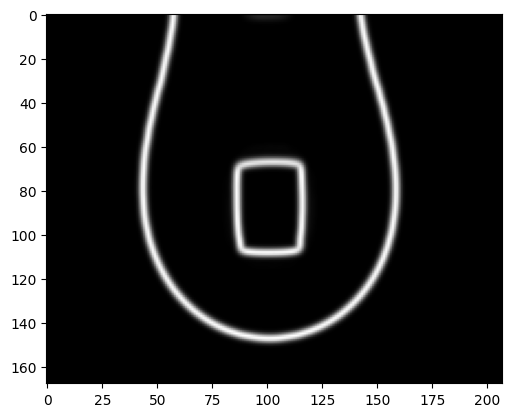

In [45]:
# Calculate the magnitude of the gradients obtained
Mag = np.hypot(gx,gy)
Mag = Normalize(Mag)
plt.imshow(Mag, cmap = plt.get_cmap('gray'))
plt.show()

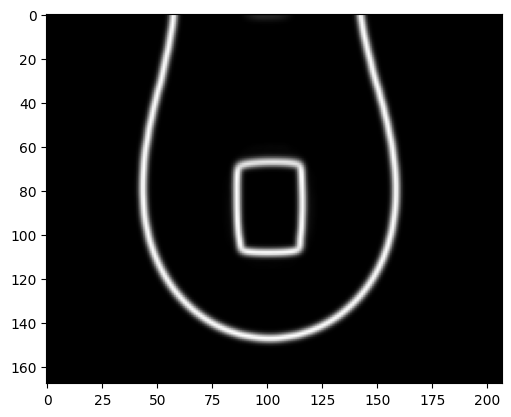

In [46]:
# Calculate the magnitude of the gradients obtained using the inbuilt function, again done to verify the correctness of the above value
mag = np.hypot(dx,dy)
mag = Normalize(mag)
plt.imshow(mag, cmap = plt.get_cmap('gray'))
plt.show()

In [47]:
# Calculate direction of the gradients
Gradient = np.degrees(np.arctan2(gy,gx))

In [48]:
# Calculate the direction of the gradients obtained using the inbuilt sobel function
gradient = np.degrees(np.arctan2(dy,dx))

In [49]:
# Do Non Maximum Suppression with interpolation to get a better estimate of the magnitude values of the pixels in the gradient direction
# This is done to get thin edges
def NonMaxSupWithInterpol(Gmag, Grad, Gx, Gy):
    NMS = np.zeros(Gmag.shape)
    
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= 0 and Grad[i,j] <= 45) or (Grad[i,j] < -135 and Grad[i,j] >= -180)):
                yBot = np.array([Gmag[i,j+1], Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i,j-1], Gmag[i-1,j-1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 45 and Grad[i,j] <= 90) or (Grad[i,j] < -90 and Grad[i,j] >= -135)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j-1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 90 and Grad[i,j] <= 135) or (Grad[i,j] < -45 and Grad[i,j] >= -90)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 135 and Grad[i,j] <= 180) or (Grad[i,j] < 0 and Grad[i,j] >= -45)):
                yBot = np.array([Gmag[i,j-1] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i,j+1] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
    
    return NMS
                
            

In [50]:
# This is also non-maxima suppression but without interpolation i.e. the pixel closest to the gradient direction is used as the estimate
def NonMaxSupWithoutInterpol(Gmag, Grad):
    NMS = np.zeros(Gmag.shape)
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= -22.5 and Grad[i,j] <= 22.5) or (Grad[i,j] <= -157.5 and Grad[i,j] >= 157.5)):
                if((Gmag[i,j] > Gmag[i,j+1]) and (Gmag[i,j] > Gmag[i,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 22.5 and Grad[i,j] <= 67.5) or (Grad[i,j] <= -112.5 and Grad[i,j] >= -157.5)):
                if((Gmag[i,j] > Gmag[i+1,j+1]) and (Gmag[i,j] > Gmag[i-1,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 67.5 and Grad[i,j] <= 112.5) or (Grad[i,j] <= -67.5 and Grad[i,j] >= -112.5)):
                if((Gmag[i,j] > Gmag[i+1,j]) and (Gmag[i,j] > Gmag[i-1,j])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 112.5 and Grad[i,j] <= 157.5) or (Grad[i,j] <= -22.5 and Grad[i,j] >= -67.5)):
                if((Gmag[i,j] > Gmag[i+1,j-1]) and (Gmag[i,j] > Gmag[i-1,j+1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0

    return NMS

C:\Users\Dmitr\AppData\Local\Temp\ipykernel_6496\2336874535.py:11: RuntimeWarning: invalid value encountered in scalar divide
  x_est = np.absolute(Gy[i,j]/Gmag[i,j])


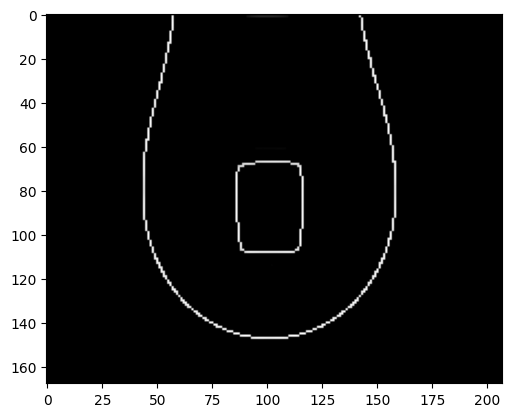

In [51]:
# Get the Non-Max Suppressed output
NMS = NonMaxSupWithInterpol(Mag, Gradient, gx, gy)
#NMS = NonMaxSupWithoutInterpol(gx, gy)
NMS = Normalize(NMS)
plt.imshow(NMS, cmap = plt.get_cmap('gray'))
plt.show()

C:\Users\Dmitr\AppData\Local\Temp\ipykernel_6496\2336874535.py:11: RuntimeWarning: invalid value encountered in scalar divide
  x_est = np.absolute(Gy[i,j]/Gmag[i,j])


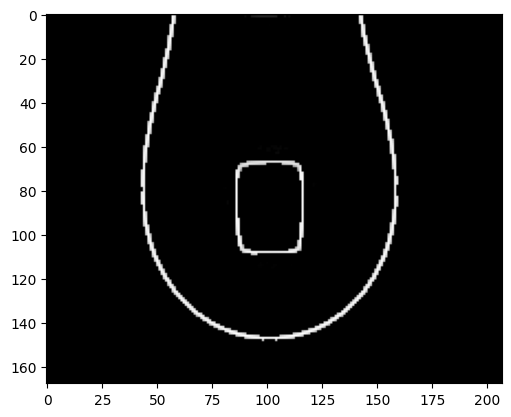

In [52]:
# Get the Non-max suppressed output on the same image but using the image using the inbuilt sobel operator
nms = NonMaxSupWithInterpol(mag, gradient, dx, dy)
nms = Normalize(nms)
plt.imshow(nms, cmap = plt.get_cmap('gray'))
plt.show()

In [53]:
# Double threshold Hysterisis
# Note that I have used a very slow iterative approach for ease of understanding, a faster implementation using recursion can be done instead
# This recursive approach would recurse through every strong edge and find all connected weak edges
def DoThreshHyst(img):
    highThresholdRatio = 0.2  
    lowThresholdRatio = 0.15 
    GSup = np.copy(img)
    h = int(GSup.shape[0])
    w = int(GSup.shape[1])
    highThreshold = np.max(GSup) * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio    
    x = 0.1
    oldx=0
    
    # The while loop is used so that the loop will keep executing till the number of strong edges do not change, i.e all weak edges connected to strong edges have been found
    while(oldx != x):
        oldx = x
        for i in range(1,h-1):
            for j in range(1,w-1):
                if(GSup[i,j] > highThreshold):
                    GSup[i,j] = 1
                elif(GSup[i,j] < lowThreshold):
                    GSup[i,j] = 0
                else:
                    if((GSup[i-1,j-1] > highThreshold) or 
                        (GSup[i-1,j] > highThreshold) or
                        (GSup[i-1,j+1] > highThreshold) or
                        (GSup[i,j-1] > highThreshold) or
                        (GSup[i,j+1] > highThreshold) or
                        (GSup[i+1,j-1] > highThreshold) or
                        (GSup[i+1,j] > highThreshold) or
                        (GSup[i+1,j+1] > highThreshold)):
                        GSup[i,j] = 1
        x = np.sum(GSup == 1)
    
    GSup = (GSup == 1) * GSup # This is done to remove/clean all the weak edges which are not connected to strong edges
    
    return GSup
                

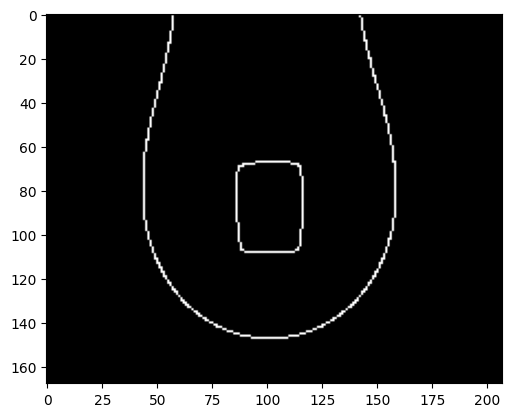

In [54]:
# The output of canny edge detection 
Final_Image = DoThreshHyst(NMS)
plt.imshow(Final_Image, cmap = plt.get_cmap('gray'))
plt.show()

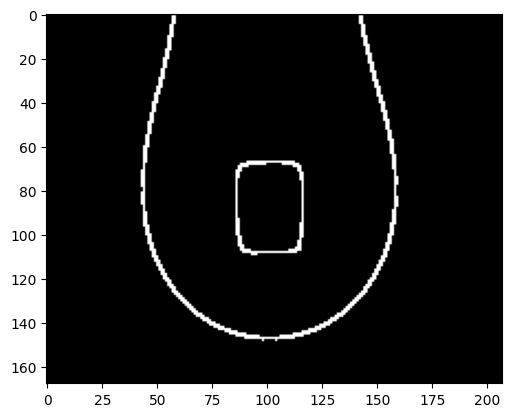

In [55]:
# The output of canny edge detection using the inputs obtaind using the inbuilt sobel operator
# Notice that the output here looks better than the one above, this might be because of the low magnitude of filter value used in our implementation of the Sobel Operator
# Changing the filter to a higher value leads to more aggressive edge extraction and thus a better output.
final_image = DoThreshHyst(nms)
plt.imshow(final_image, cmap = plt.get_cmap('gray'))
plt.show()

2


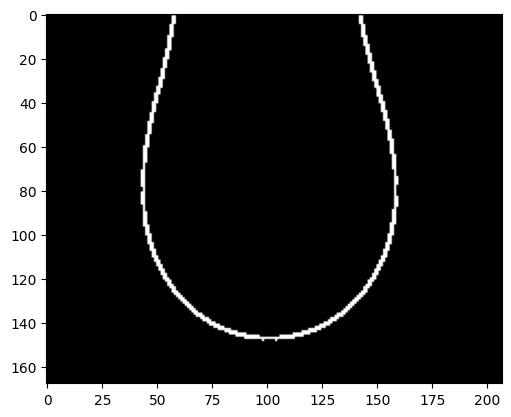

In [56]:
# label connected components
labeled_image, num_features = ndimage.label(final_image)
# Remove feature 2 which is the internal noise from light
labeled_image[labeled_image == 2] = 0
plt.imshow(labeled_image, cmap = plt.get_cmap('gray'))
plt.show()